# Feed-Forward Neural Networks, Autoencoders, and Generative Models


# 1 Introduction

In this assignment, we first use simple supervised networks to classify handwritten digits, and will then apply these techniques to generate novel images of digits using Variational Autoencoders and GANs. Afterwards, we will apply information theoretic measures to assess the success of the generative models.

# 2 MNIST Classification


In [30]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2.1 Downloading MNIST

In [31]:
mnist_train = datasets.MNIST(root = 'data', train=True, download=True, transform = transforms.ToTensor())
mnist_test = datasets.MNIST(root = 'data', train=False, download=True,transform = transforms.ToTensor())

In [32]:
def evaluate(model, evaluation_set, loss_fn):
    """
    Evaluates the given model on the given dataset.
    Returns the percentage of correct classifications out of total classifications.
    """
    with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
        # TODO: Fill in the rest of the evaluation function.
        losses = []
        sum_total = 0
        for data, targets in evaluation_set:
          data = data.to(device)
          targets = targets.to(device)
          model_input = data.view(-1, 784)
          out = model(model_input)
          arg_maxed = torch.argmax(out, dim = 1)
          
          sum_total += (arg_maxed == targets).float().sum()
          losses.append(loss_fn(out, targets).item())
        loss = sum(losses) / len(losses)
        accuracy =  100 * sum_total / len(evaluation_set.dataset)
    return accuracy, loss

def train(model,loss_fn, optimizer, train_loader, test_loader):
    """
    This is a standard training loop, which leaves some parts to be filled in.
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """
    num_epochs = 150 # obviously, this is too many. I don't know what this author was thinking.
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    for epoch in range(num_epochs):
        # loop through each data point in the training set
        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            
            # run the model on the data
            model_input = data.view(-1, 784)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
            out = model(model_input)

            # Calculate the loss
            loss = loss_fn(out,targets)

            # Find the gradients of our loss via backpropogation
            loss.backward()

            # Adjust accordingly with the optimizer
            optimizer.step()

        # Give status reports every 100 epochs
        if epoch % 100==0:
            print(f" EPOCH {epoch}. Progress: {epoch/num_epochs*100}%. ")
            tr_acc, tr_loss = evaluate(model, train_loader, loss_fn)
            te_acc, te_loss = evaluate(model, test_loader, loss_fn)
            train_loss.append(tr_loss)
            train_acc.append(tr_acc)
            test_loss.append(te_loss)
            test_acc.append(te_acc)

            
            print(f" Train accuracy: {tr_acc}. Test accuracy: {te_acc}") #TODO: implement the evaluate function to provide performance statistics during training.

    return train_loss, train_acc, test_loss, test_acc


## 2.2 Logistic Regression
> First, we will explore implementing a simple model that can take in images of handwritten digits and classify them from 0 to 9. We will do this using a multinomial logistic regression model trained with gradient descent。

In [33]:
from torch.nn.functional import softmax
import torch.nn.functional as F
from torch import optim, nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import torch

In [34]:
class LogisticRegression(nn.Module): # initialize a pytorch neural network module
    def __init__(self): # initialize the model
        super(LogisticRegression, self).__init__() # call for the parent class to initialize
        # you can define variables here that apply to the entire model (e.g. weights, biases, layers...)
        # this model only has two parameters: the weight, and the bias.
        # here's how you can initialize the weight:
        # W = nn.Parameter(torch.zeros(shape)) # this creates a model parameter out of a torch tensor of the specified shape
        # ... torch.zeros is much like numpy.zeros, except optimized for backpropogation. We make it a model parameter and so it will be updated by gradient descent.

        # create a bias variable here
        self.W = nn.Parameter(torch.zeros((784, 10)), requires_grad = True)
        self.b = nn.Parameter(torch.zeros((1, 10)), requires_grad = True)


    def forward(self, x):
        """
        this is the function that will be executed when we call the logistic regression on data.
        INPUT:
            x, an MNIST image represented as a tensor of shape 784
        OUTPUT:
            predictions, a tensor of shape 10. If using CrossEntropyLoss, your model will be trained to put the largest number in the index it believes corresponds to the correct class.
        """
        # put the logic here.
        predictions = torch.matmul(x, self.W) + self.b
        predictions = F.sigmoid(predictions)

        return predictions

In [35]:
model = LogisticRegression().to(device)
# initialize the optimizer, and set the learning rate
SGD = torch.optim.SGD(model.parameters(), lr = 5e-2) # This is absurdly high.
# initialize the loss function. You don't want to use this one, so change it accordingly
loss_fn = torch.nn.CrossEntropyLoss()
batch_size = 128
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)
train_loss, train_acc, test_loss, test_acc = train(model = model,loss_fn = loss_fn, optimizer = SGD, train_loader = train_loader, test_loader = test_loader)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 EPOCH 0. Progress: 0.0%. 
 Train accuracy: 82.72666931152344. Test accuracy: 83.56999969482422
 EPOCH 100. Progress: 66.66666666666666%. 
 Train accuracy: 89.82167053222656. Test accuracy: 90.40999603271484


Question 2.2.1. What percentage classification accuracy did your simple network achieve?

~91%

## 2.3 Feed-forward Neural Network

In [ ]:
class FeedForwardNet(nn.Module):
    """ Simple feed forward network with one hidden layer."""
    # Here, you should place an exact copy of the code from the LogisticRegression class, with two modifications:
    # 1. Add another weight and bias vector to represent the hidden layer
    # 2. In the forward function, add some type of nonlinearity to the output of the first layer, then pass it onto the hidden layer.
    def __init__(self):
      super(FeedForwardNet, self).__init__()
      self.W1 = nn.Parameter(torch.randn((784, 128)), requires_grad = True)
      self.b1 = nn.Parameter(torch.zeros((1, 128)), requires_grad = True)
      self.W2 = nn.Parameter(torch.randn((128, 10)), requires_grad = True)
      self.b2 = nn.Parameter(torch.zeros((1, 10)), requires_grad = True)

    def forward(self, x):
      predictions = torch.matmul(x, self.W1) + self.b1
      predictions = F.relu(predictions)
      predictions = torch.matmul(predictions, self.W2) + self.b2
      predictions = softmax(predictions)
      return predictions

In [ ]:
model = FeedForwardNet().to(device)
# initialize the optimizer, and set the learning rate
adam = torch.optim.Adam(model.parameters(), lr = 3e-3) # This is absurdly high.
# initialize the loss function. You don't want to use this one, so change it accordingly
loss_fn = torch.nn.CrossEntropyLoss()
batch_size = 128
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)
train_loss, train_acc, test_loss, test_acc = train(model = model,loss_fn = loss_fn, optimizer = adam, train_loader = train_loader, test_loader = test_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 EPOCH 0. Progress: 0.0%. 
 Train accuracy: 67.92500305175781. Test accuracy: 68.18999481201172
 EPOCH 100. Progress: 20.0%. 
 Train accuracy: 88.91166687011719. Test accuracy: 87.9000015258789
 EPOCH 200. Progress: 40.0%. 
 Train accuracy: 89.20833587646484. Test accuracy: 87.94999694824219
 EPOCH 300. Progress: 60.0%. 
 Train accuracy: 89.44667053222656. Test accuracy: 88.04000091552734
 EPOCH 400. Progress: 80.0%. 
 Train accuracy: 89.66666412353516. Test accuracy: 88.29999542236328


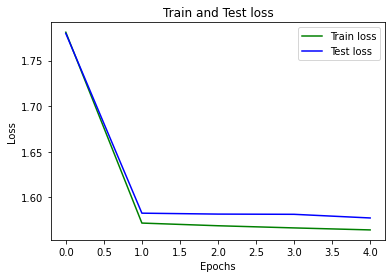

In [ ]:
epochs = range(0,len(train_loss))
plt.plot(epochs, train_loss, 'g', label='Train loss')
plt.plot(epochs, test_loss, 'b', label='Test loss')
plt.title('Train and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix as conf_mat
labels = []
outs = []
with torch.no_grad():
  for i, (inputs, classes) in enumerate(test_loader):
    inputs = inputs.to(device)
    classes = classes.to(device)
    outputs = model(inputs.view(-1, 784))
    preds = torch.argmax(outputs, 1)
    labels.extend(classes.detach().cpu().numpy())
    outs.extend(preds.detach().cpu().numpy())

conf_mat(labels, outs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


array([[ 973,    0,    1,    1,    0,    0,    1,    2,    2,    0],
       [   0, 1123,    3,    1,    0,    0,    5,    1,    2,    0],
       [   2,    2, 1006,    6,    1,    0,    4,    6,    5,    0],
       [   0,    0,    6,  980,    0,   13,    0,    3,    8,    0],
       [   1,    1,    2,    0,  972,    0,    6,    0,    0,    0],
       [   4,    0,    0,    7,    3,  861,    9,    1,    7,    0],
       [   3,    1,    1,    1,    1,    2,  946,    0,    3,    0],
       [   1,    5,    8,    1,    1,    1,    0, 1006,    5,    0],
       [   5,    1,    1,    4,    1,    0,    2,    5,  955,    0],
       [  13,   11,    3,  108,  595,   69,    0,  105,  105,    0]])

Question 2.3.1. What percentage classification accuracy does this more complex network achieve?

89%

Question 2.3.2. Create a plot of the training and test error vs the number of iterations. How many iterations
are sufficient to reach good performance?

around 150 epochs seems to be sufficient

Question 2.3.3. Print the confusion matrix showing which digits were misclassified, and what they were
misclassified as. What numbers are frequently confused with one another by your model?

For some reason there seems to be a problem with the 9 digit. It was never classifier correctly and it is often misclassified with the 4 digit.

Question 2.3.4. Experiment with the learning rate, optimizer and activation function of your network.
Report the best accuracy and briefly describe the training scheme that reached this accuracy.

Using relu activation functions with an Adam optimizer this accuracy was achieved. It worked best with 1e-3 learning rate. I tried with various learning rates and it seemed Adam with this learning rate worked best

# 3 Autoencoder

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.enc_lin1 = nn.Linear(784, 1000)
        self.enc_lin2 = nn.Linear(1000, 500)
        self.enc_lin3 = nn.Linear(500, 250)
        self.enc_lin4 = nn.Linear(250, 2)

        self.dec_lin1 = nn.Linear(2, 250)
        self.dec_lin2 = nn.Linear(250, 500)
        self.dec_lin3 = nn.Linear(500, 1000)
        self.dec_lin4 = nn.Linear(1000, 784)


    def encode(self, x):
        x = F.tanh(self.enc_lin1(x))
        x = F.tanh(self.enc_lin2(x))
        x = F.tanh(self.enc_lin3(x))
        x = self.enc_lin4(x)

        # ... additional layers, plus possible nonlinearities.
        return x

    def decode(self, z):
        # ditto, but in reverse
        z = F.tanh(self.dec_lin1(z))
        z = F.tanh(self.dec_lin2(z))
        z = F.tanh(self.dec_lin3(z))
        z = F.sigmoid(self.dec_lin4(z))

        return z

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)


In [ ]:
import matplotlib.pyplot as plt

def evaluate_ae(model, evaluation_set, loss_fn):
    """
    Evaluates the given model on the given dataset.
    Returns the percentage of correct classifications out of total classifications.
    """
    with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
        # TODO: Fill in the rest of the evaluation function.
        losses = []
        sum_total = 0
        for ind, (data, targets) in enumerate(evaluation_set):
          data = data.to(device)
          model_input = data.view(-1, 784)
          out = model(model_input)
          # if ind == 0:
          #   visualise_output(model_input, model)
          sum_total += (out == model_input).float().sum()
          losses.append(loss_fn(out, model_input).item())
        loss = sum(losses) / len(losses)
        accuracy =  100 * sum_total / len(evaluation_set.dataset)
    return accuracy, loss

def train_ae(model,loss_fn, optimizer, train_loader, test_loader):
    """
    This is a standard training loop, which leaves some parts to be filled in.
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """
    num_epochs = 500 # obviously, this is too many. I don't know what this author was thinking.
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    to_graph = {}
    while True:
      for data, targets in test_loader:
        for d, t in zip(data, targets):
          if int(t) not in to_graph.keys():
            to_graph[int(t)] = d
          if len(to_graph) == 10:
            break
        if len(to_graph) == 10:
            break
      if len(to_graph) == 10:
            break

    for epoch in range(num_epochs):
        # loop through each data point in the training set
        for data, targets in train_loader:
            optimizer.zero_grad()
            data = data.to(device)
            # run the model on the data
            model_input = data.view(-1, 784)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
            out = model(model_input)

            # Calculate the loss
            loss = loss_fn(out, model_input)

            # Find the gradients of our loss via backpropogation
            loss.backward()

            # Adjust accordingly with the optimizer
            optimizer.step()

        # Give status reports every 100 epochs
        if epoch % 100==0:
            print(f" EPOCH {epoch}. Progress: {epoch/num_epochs*100}%. ")
            tr_acc, tr_loss = evaluate_ae(model, train_loader, loss_fn)
            te_acc, te_loss = evaluate_ae(model, test_loader, loss_fn)
            train_loss.append(tr_loss)
            train_acc.append(tr_acc)
            test_loss.append(te_loss)
            test_acc.append(te_acc)
            

            
            # im = next(iter(train_loader))[0][0]
            # plt.imshow(im.squeeze())
            # plt.show()
            # # import pdb; pdb.set_trace()

            # with torch.no_grad():
            #   plt.imshow(torch.reshape(model(im.view(-1, 784)), (28,28)).numpy())
            #   plt.show()

            
            print(f" Train Loss: {tr_loss}. Test Loss: {te_loss}") #TODO: implement the evaluate function to provide performance statistics during training.

    for label, data in to_graph.items():
      plt.imshow(data.squeeze())
      plt.show()
      with torch.no_grad():
        plt.imshow(torch.reshape(model(data.view(-1, 784)), (28,28)).numpy())
        plt.show()
    return train_loss, train_acc, test_loss, test_acc

## 3.1 MNIST

In [ ]:
model = Autoencoder().to(device)
# initialize the optimizer, and set the learning rate
optimizer = torch.optim.Adam(model.parameters(), lr = 0.003) # This is absurdly high.
# initialize the loss function. You don't want to use this one, so change it accordingly
loss_fn = torch.nn.MSELoss()
batch_size = 128
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)
train_ae(model = model,loss_fn = loss_fn, optimizer = optimizer, train_loader = train_loader, test_loader = test_loader)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 EPOCH 0. Progress: 0.0%. 
 Train Loss: 0.04769748952120606. Test Loss: 0.047753466222482395
 EPOCH 100. Progress: 20.0%. 
 EPOCH 200. Progress: 40.0%. 
 Train Loss: 0.046536173179014914. Test Loss: 0.04638722930339318
 EPOCH 300. Progress: 60.0%. 
 Train Loss: 0.051131408375654136. Test Loss: 0.05109376780971696
 EPOCH 400. Progress: 80.0%. 
 Train Loss: 0.0534530708641767. Test Loss: 0.05327377793721006


NameError: ignored

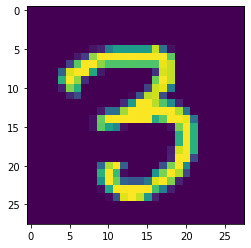

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


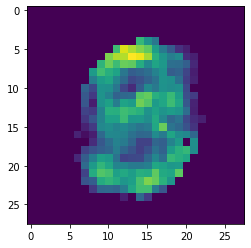

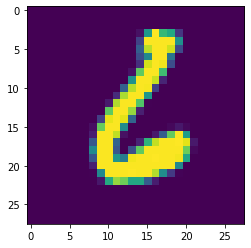

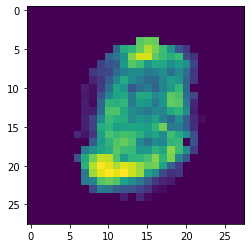

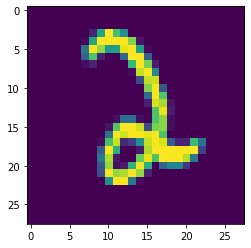

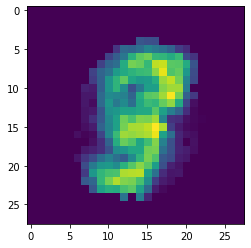

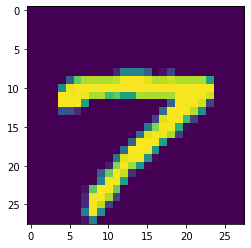

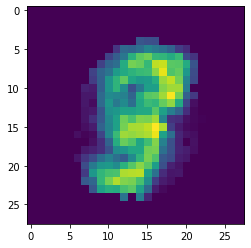

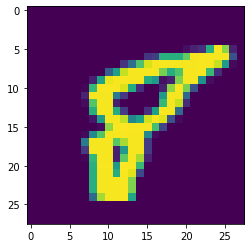

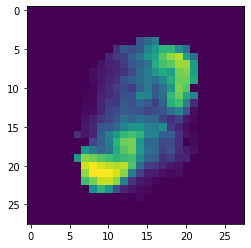

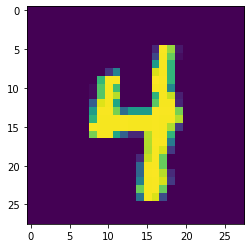

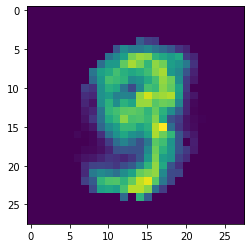

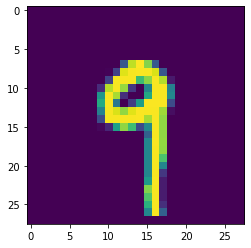

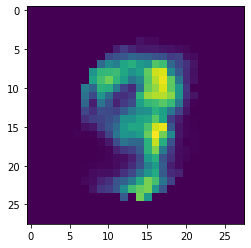

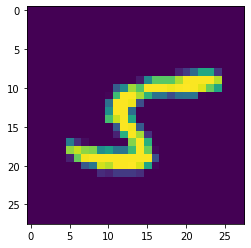

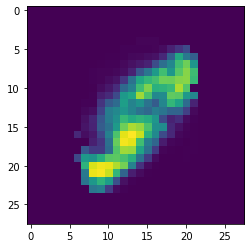

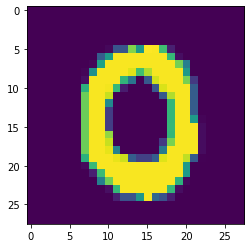

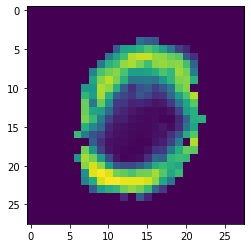

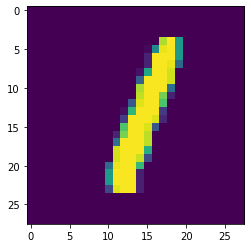

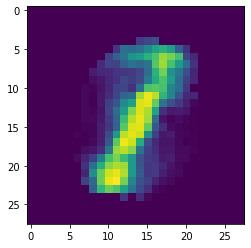

In [ ]:
import matplotlib.pyplot as plt

to_graph = {}
while True:
  for data, targets in train_loader:
    for d, t in zip(data, targets):
      if int(t) not in to_graph.keys():
        to_graph[int(t)] = d
      if len(to_graph) == 10:
        break
    if len(to_graph) == 10:
        break
  if len(to_graph) == 10:
        break

for label, data in to_graph.items():
  plt.imshow(data.squeeze())
  plt.show()
  with torch.no_grad():
    data = data.to(device)
    plt.imshow(torch.reshape(model(data.view(-1, 784)), (28,28)).cpu().numpy())
    plt.show()

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


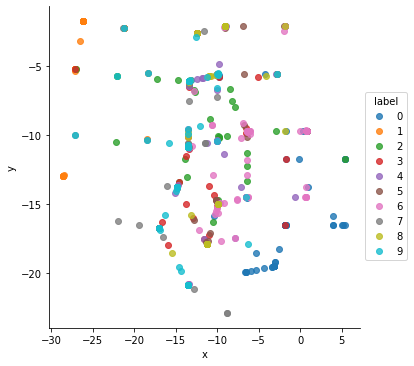

In [ ]:


thousand_loader = torch.utils.data.DataLoader(mnist_train, batch_size = 1000, shuffle = True)
for data, target in thousand_loader:
  with torch.no_grad():
    data = data.to(device)
    model_input = data.view(-1, 784)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    out = model.encode(model_input).detach().cpu().numpy()
    labels = target
    break

df = {'x': out[:, 0], 'y': out[:, 1], 'label': labels.numpy()}



data = pd.DataFrame(df)
facet = sns.lmplot(data=data, x='x', y='y', hue='label', 
                   fit_reg=False, legend=False)

#add a legend
leg = facet.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)


Question 3.1.1. Do the colors easily separate, or are they all clumped together? Which numbers are frequently embedded close together, and what does this mean?

The colors easily separate, but it does not seem like there are any distinct custers. Perhaps with optimized training there would be. The 1s and 0s seem to be pretty dictinct, but something like an 8 which has many lines, seems to be scattered throughout. It also seems like 2s and 6s are somewhat close, which means the network learned these embeddings to have similar values.

Question 3.1.2. How realistic were the images you generated by interpolating between points in the latent space? Can you think of a better way to generate images with an autoencoder?

The generated images were not too realistic. Perhaps with more dimensions between the encoder and decoder, we could see better results.

## 3.2 Biological Data: Retinal Bipolar Dataset

In [ ]:
import pickle
with open('retinal-bipolar-data.pickle', 'rb') as f:
  retinal = pickle.load(f)
with open('retinal-bipolar-metadata.pickle', 'rb') as f:
  retinal_meta = pickle.load(f)

In [ ]:
retinal.shape

(21552, 15524)

In [ ]:
msk = np.random.rand(len(retinal)) < 0.8

ret_train = torch.Tensor(retinal[msk].values.astype(np.float32))
ret_tr_y = torch.Tensor(retinal_meta[msk]['CLUSTER'].values.astype(np.float32))
ret_test = torch.Tensor(retinal[~msk].values.astype(np.float32))
ret_te_y = torch.Tensor(retinal_meta[~msk]['CLUSTER'].values.astype(np.float32))

In [ ]:
ret_train = torch.utils.data.TensorDataset(ret_train, ret_tr_y)
ret_test = torch.utils.data.TensorDataset(ret_test, ret_te_y)

In [ ]:
class Ret_Autoencoder(Autoencoder):
  def __init__(self, input_size):
    super(Autoencoder, self).__init__()
    self.enc_lin1 = nn.Linear(input_size, 1000)
    self.enc_lin2 = nn.Linear(1000, 500)
    self.enc_lin3 = nn.Linear(500, 250)
    self.enc_lin4 = nn.Linear(250, 2)

    self.dec_lin1 = nn.Linear(2, 250)
    self.dec_lin2 = nn.Linear(250, 500)
    self.dec_lin3 = nn.Linear(500, 1000)
    self.dec_lin4 = nn.Linear(1000, input_size)

  def decode(self, z):
    # ditto, but in reverse
    z = F.tanh(self.dec_lin1(z))
    z = F.tanh(self.dec_lin2(z))
    z = F.tanh(self.dec_lin3(z))
    z = self.dec_lin4(z)

    return z


In [ ]:
import matplotlib.pyplot as plt

def evaluate_ret_ae(model, evaluation_set, loss_fn):
    """
    Evaluates the given model on the given dataset.
    Returns the percentage of correct classifications out of total classifications.
    """
    with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
        # TODO: Fill in the rest of the evaluation function.
        losses = []
        sum_total = 0
        for ind, (data, targets) in enumerate(evaluation_set):
          data = data.to(device)
          model_input = data
          out = model(model_input)
          # if ind == 0:
          #   visualise_output(model_input, model)
          sum_total += (out == model_input).float().sum()
          losses.append(loss_fn(out, model_input).item())
        loss = sum(losses) / len(losses)
        accuracy =  100 * sum_total / len(evaluation_set.dataset)
    return accuracy, loss

def train_ret_ae(model,loss_fn, optimizer, train_loader, test_loader):
    """
    This is a standard training loop, which leaves some parts to be filled in.
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """
    num_epochs = 500 # obviously, this is too many. I don't know what this author was thinking.
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    for epoch in range(num_epochs):
        # loop through each data point in the training set
        for data, targets in train_loader:
            optimizer.zero_grad()
            data = data.to(device)
            # run the model on the data
            model_input = data
            out = model(model_input)

            # Calculate the loss
            loss = loss_fn(out, model_input)

            # Find the gradients of our loss via backpropogation
            loss.backward()

            # Adjust accordingly with the optimizer
            optimizer.step()

        # Give status reports every 100 epochs
        if epoch % 100==0:
            print(f" EPOCH {epoch}. Progress: {epoch/num_epochs*100}%. ")
            tr_acc, tr_loss = evaluate_ret_ae(model, train_loader, loss_fn)
            te_acc, te_loss = evaluate_ret_ae(model, test_loader, loss_fn)
            train_loss.append(tr_loss)
            train_acc.append(tr_acc)
            test_loss.append(te_loss)
            test_acc.append(te_acc)
            
            print(f" Train Loss: {tr_loss}. Test Loss: {te_loss}") #TODO: implement the evaluate function to provide performance statistics during training.

    return train_loss, train_acc, test_loss, test_acc

In [ ]:
model = Ret_Autoencoder(input_size = 15524).to(device)
# initialize the optimizer, and set the learning rate
optimizer = torch.optim.Adam(model.parameters(), lr = 0.003) # This is absurdly high.
# initialize the loss function. You don't want to use this one, so change it accordingly
loss_fn = torch.nn.MSELoss()
batch_size = 128
train_loader = torch.utils.data.DataLoader(ret_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(ret_test, batch_size=batch_size, shuffle=True)
train_ret_ae(model = model,loss_fn = loss_fn, optimizer = optimizer, train_loader = train_loader, test_loader = test_loader)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


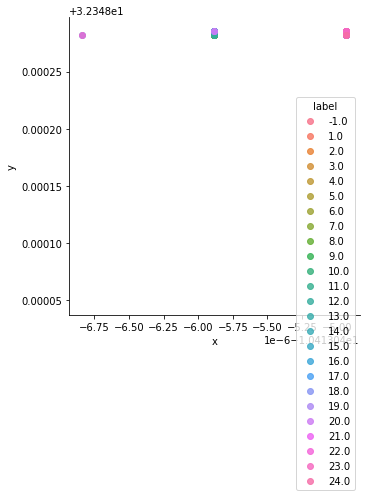

In [ ]:
thousand_loader = torch.utils.data.DataLoader(ret_test, batch_size = 1000, shuffle = True)
for data, target in thousand_loader:
  with torch.no_grad():
    data = data.to(device)
    model_input = data
    out = model.encode(model_input).detach().cpu().numpy()
    labels = target
    break

df = {'x': out[:, 0], 'y': out[:, 1], 'label': labels.numpy()}



data = pd.DataFrame(df)
facet = sns.lmplot(data=data, x='x', y='y', hue='label', 
                   fit_reg=False, legend=False)

#add a legend
leg = facet.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)

Question 3.2.1. How many clusters are visible in the embedding? Do they correspond to the cluster labels?

It seems like there was only three clusters. The y dimension seems to have very little variance. It does seem, however, that there is a trend, where numbers found the same x value and ended up in three different bins.

# 4 Generative Models

## 4.1 The Variational Autoencoder

In [ ]:
##### vae.py

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

batch_size = 128
epochs = 10
seed = 1
log_interval = 10


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar





def VAE_loss_function(recon_x, x, mu, logvar):
    # TO DO: Implement reconstruction + KL divergence losses summed over all elements and batch

    # see lecture 12 slides for more information on the VAE loss function
    # for additional information on computing KL divergence
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114

    # x = x.squeeze(1)
    recon_loss = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = VAE_loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += VAE_loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))




In [ ]:
!mkdir results

In [ ]:
#if name = main
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                    'results/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 547.250000
Train Epoch: 1 [1280/60000 (2%)]	Loss: 304.746094
Train Epoch: 1 [2560/60000 (4%)]	Loss: 233.603378
Train Epoch: 1 [3840/60000 (6%)]	Loss: 221.929214
Train Epoch: 1 [5120/60000 (9%)]	Loss: 218.519470
Train Epoch: 1 [6400/60000 (11%)]	Loss: 215.135056
Train Epoch: 1 [7680/60000 (13%)]	Loss: 207.176376
Train Epoch: 1 [8960/60000 (15%)]	Loss: 203.229523
Train Epoch: 1 [10240/60000 (17%)]	Loss: 188.281433
Train Epoch: 1 [11520/60000 (19%)]	Loss: 188.851898
Train Epoch: 1 [12800/60000 (21%)]	Loss: 182.265137
Train Epoch: 1 [14080/60000 (23%)]	Loss: 179.018768
Train Epoch: 1 [15360/60000 (26%)]	Loss: 177.512329
Train Epoch: 1 [16640/60000 (28%)]	Loss: 162.004517
Train Epoch: 1 [17920/60000 (30%)]	Loss: 162.069183
Train Epoch: 1 [19200/60000 (32%)]	Loss: 163.561600
Train Epoch: 1 [20480/60000 (34%)]	Loss: 155.700745
Train Epoch: 1 [21760/60000 (36%)]	Loss: 158.180450
Train Epoch: 1 [23040/60000 (38%)]	Loss: 162.674438
Train Epoch: 1 [24320/60000 

KeyboardInterrupt: ignored

IndexError: ignored

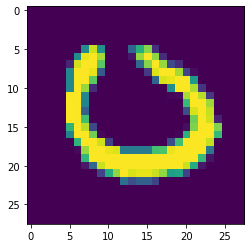

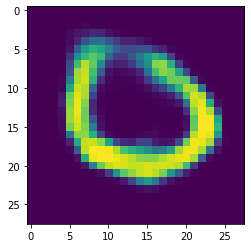

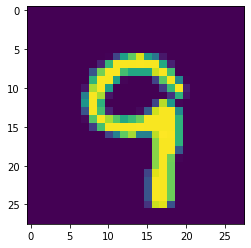

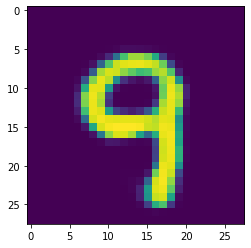

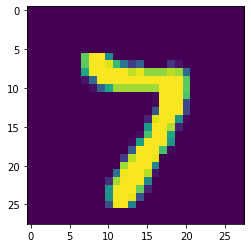

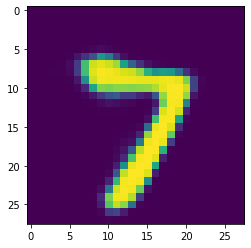

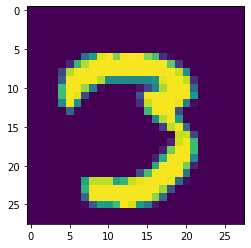

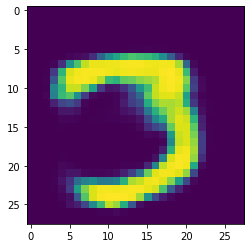

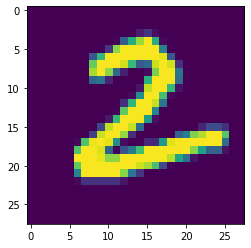

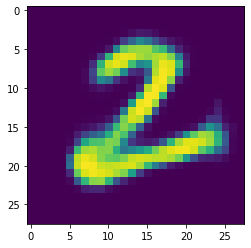

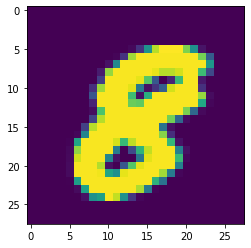

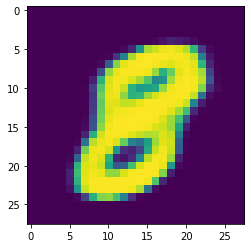

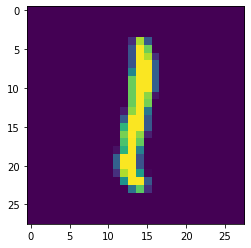

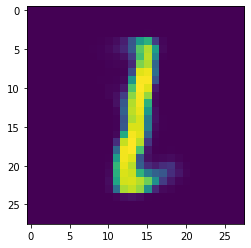

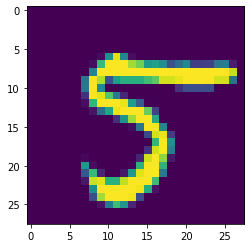

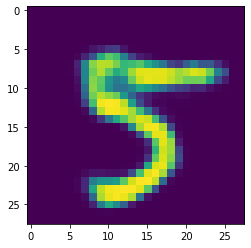

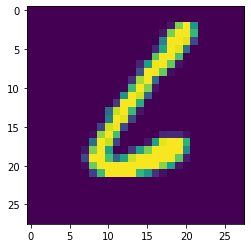

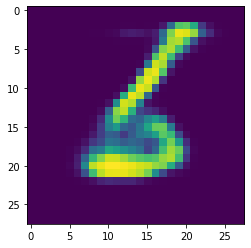

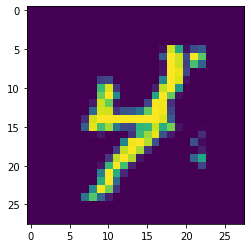

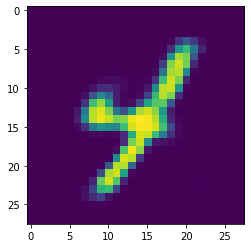

In [ ]:
to_graph = {}
while True:
  for data, targets in test_loader:
    for d, t in zip(data, targets):
      if int(t) not in to_graph.keys():
        to_graph[int(t)] = d[0]
      if len(to_graph) == 10:
        break
    if len(to_graph) == 10:
        break
  if len(to_graph) == 10:
        break

for label, data in to_graph.items():
  plt.imshow(data.squeeze())
  plt.show()
  with torch.no_grad():
    data = data.to(device)
    z, _, _ = model(data.view(-1, 784))
    plt.imshow(torch.reshape(z, (28,28)).cpu().numpy())
    plt.show()

In [ ]:
!pip install phate scprep

Calculating PHATE...
  Running PHATE on 1000 observations and 20 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.06 seconds.
  Calculating optimal t...
    Automatically selected t = 30
  Calculated optimal t in 0.71 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.43 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.02 seconds.
Calculated PHATE in 2.23 seconds.


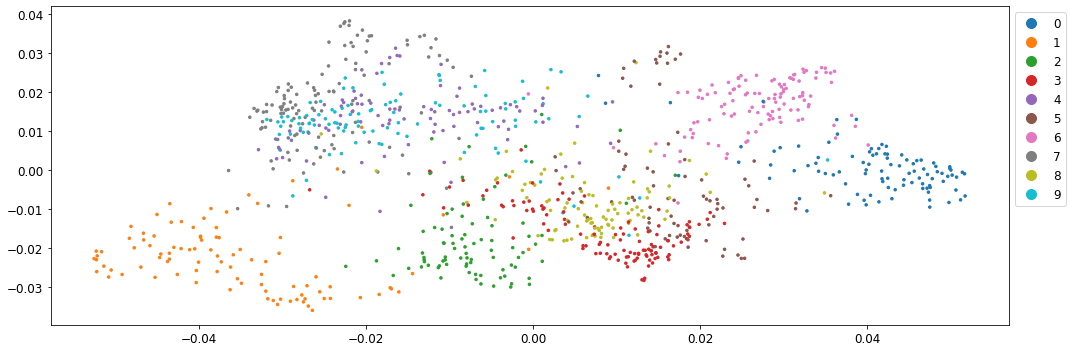

In [ ]:
import phate
import scprep
thousand_loader = torch.utils.data.DataLoader(mnist_train, batch_size = 1000, shuffle = True)
for data, target in thousand_loader:
  with torch.no_grad():
    data = data.to(device)
    model_input = data.view(-1, 784)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    mu, log = model.encode(model_input)
    out = model.reparameterize(mu, log)
    out = out.detach().cpu().numpy()
    labels = target
    break

subsample_data_pc, subsample_meta = scprep.select.subsample(out, labels, n = 1000)
data_phate = phate.PHATE().fit_transform(subsample_data_pc)

scprep.plot.scatter2d(data_phate, c=list(subsample_meta), figsize=(15,5), legend_anchor=(1,1))

# df = {'x': out[:, 0], 'y': out[:, 1], 'label': labels.numpy()}



# data = pd.DataFrame(df)
# facet = sns.lmplot(data=data, x='x', y='y', hue='label', 
#                    fit_reg=False, legend=False)

# #add a legend
# leg = facet.ax.legend(bbox_to_anchor=[1, 0.75],
#                          title="label", fancybox=True)


Question 4.1.1. How does the VAE’s latent space compare to the latent space of your previous autoencoder? Do the generated images have more clarity? Is this most noticeable between or within classes?

The latent space seems to be much better defined for the VAE, and the generated images absolutely have more clarity. It is most noticable between classes.

Question 4.1.2. In what situations would a VAE be more useful than a vanilla autoencoder, and when
would you prefer a vanilla autoencoder to a VAE?

VAEs should perform better on larger datasets, and they perform better to distinguish between classes. I think vanilla AE should be used first, if they are sufficient, then use it, as it is a simpler model. If the data has a lot of similarities, then an AE should be good, but if it is important to make distinctions between categories, then VAE.

Question 4.1.3. The distance between embeddings in your first autoencoder provided some measure of the
similarity between digits. To what extent is this preserved, or improved, by the VAE?

This is preserved less. This is by design of the VAE.

## 4.2 GANs

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
from torch.autograd import Variable
import imageio
import numpy as np
import matplotlib
import math
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

In [ ]:
!mkdir outputs

mkdir: cannot create directory ‘outputs’: File exists


In [ ]:
#### GAN.py
criterion = nn.BCELoss() 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz # the dimension of the random noise used to seed the Generator
        self.main = nn.Sequential( # nn.sequential is a handy way of combining multiple layers.
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)


def train_discriminator(optimizer, real_data, fake_data):
    """
    Train the discriminator on a minibatch of data.
    INPUTS
        :param optimizer: the optimizer used for training
        :param real_data: the batch of training data
        :param fake_data: the data generated by the generator from random noise
    The discriminator will incur two losses: one from trying to classify the real data, and another from classifying the fake data.
    TODO: Fill in this function.
    It should
    1. Run the discriminator on the real_data and the fake_data
    2. Compute and sum the respective loss terms (described in the assignment)
    3. Backpropogate the loss (e.g. loss.backward()), and perform optimization (e.g. optimizer.step()).
    """
    # optimizer.zero_grad()
    fake_out = discriminator(fake_data)
    real_out = discriminator(real_data)
    y_fake = Variable(torch.zeros(batch_size, 1, device = device))
    y_real = Variable(torch.ones(batch_size, 1, device = device))
    D_real_loss = criterion(real_out, y_real)
    D_fake_loss = criterion(fake_out, y_fake)
    # loss = -0.5 * y_real * torch.clamp(torch.log((real_out)), 1e-3, 1e3) - 0.5 * (1 - y_fake) * torch.clamp(torch.log(1 - fake_out), 1e-3, 1e3)
    # loss = loss.sum()
    # import pdb; pdb.set_trace()
    loss = (D_fake_loss + D_real_loss) / 2

    loss.backward()
    # optimizer.step()

    # we'll return the loss for book-keeping purposes. (E.g. if you want to make plots of the loss.)

    return loss.item(), optimizer

def train_generator(optimizer, fake_data):
    """
    Performs a single training step on the generator.
    :param optimizer: the optimizer
    :param fake_data: forgeries, created by the generator from random noise. (Done before calling this function.)
    :return:  the generator's loss
    TODO: Fill in this function
    It should
    1. Run the discriminator on the fake_data
    2. compute the resultant loss for the generator (as described in the assignment)
    3. Backpropagate the loss, and perform optimization
    """
    # import pdb; pdb.set_trace()

    # with torch.no_grad():
    # optimizer.zero_grad()
    fake_out = discriminator(fake_data)
    y = Variable(torch.ones(batch_size, 1).to(device))
    loss = criterion(fake_out, y)
    # loss = -0.5 * y * torch.clamp(torch.log(fake_out), 1e-3, 1e3)
    # loss = loss.sum()
    # import pdb; pdb.set_trace()
    loss.backward()
    # optimizer.step()
    return loss.item(), optimizer

# import data
batch_size = 100
train_data = datasets.MNIST(
    root='../data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

num_epochs = 1000
nz = 25# dimension of random noise
generator = Generator(nz)
generator = generator.to(device)
discriminator = Discriminator()
discriminator = discriminator.to(device)
g_optimizer = optim.Adam(generator.parameters(), lr=3e-4)
d_optimizer = optim.Adam(discriminator.parameters(), lr=3e-4)
#TODO: Build a training loop for the GAN
# For each epoch, you'll
# 1. Loop through the training data. For each batch, feed random noise into the generator to generate fake_data of the corresponding size.
# 2. Feed the fake data and real data into the train_discriminator and train_generator functions
# At the end of each epoch, use the below functions to save a grid of generated images.
for epoch in range(num_epochs):
    for data, _ in train_loader:
        # perform training
        data = data.to(device)
        g_optimizer.zero_grad()
        

        noise = torch.randn((batch_size, nz), device=device)
        noise = torch.clamp(noise, 1e-8, 1)
        fake_data = generator(noise)
        gen_loss, g_optimizer = train_generator(optimizer = g_optimizer, fake_data = fake_data)
        g_optimizer.step()

        d_optimizer.zero_grad()
        noise = torch.randn((batch_size, nz), device=device)
        noise = torch.clamp(noise, 1e-8, 1)
        fake_data = generator(noise)
        dis_loss, d_optimizer = train_discriminator(optimizer = d_optimizer, real_data = data, fake_data = fake_data)

        
        d_optimizer.step()
    # reshape the image tensors into a grid
    if epoch % 100 == 0:
      print('Epoch: {} \t Gen loss: {} \t Dis loss: {}'.format(epoch, gen_loss, dis_loss))
      print('youre past {}'.format(epoch))
    generated_img = make_grid(fake_data)
    # save the generated torch tensor images
    save_image(generated_img, f"outputs/gen_img{epoch}.png")

Epoch: 0 	 Gen loss: 9.10543155670166 	 Dis loss: 0.4813183546066284
youre past 0
Epoch: 100 	 Gen loss: 1.3410712480545044 	 Dis loss: 0.4673610329627991
youre past 100


Question 4.2.1. Which generates more realistic images: your GAN, or your VAE? Why do you think this
is?

From what I saw, the VAE generated more realistic images. I assume this is because there is an actual input to the VAE to reconstruct it whereas the GAN generalizes over the noise

Question 4.2.2. Does your GAN appear to generate all digits in equal number, or has it specialized in a
smaller number of digits? If so, why might this be?

It seems to generate 0s more than anything. This is probably because so many numbers have curves, 2, 3, 5, 6, 8, 9, 0 that having a number that is essentially the average would be the easiest for the generator to learn. It also seems to make a lot of 3s, possibly because the left side of many numbers is open. interestingly enough, the generator doesn't appear to make many 8s. 



In [ ]:
model = LogisticRegression().to(device)
# initialize the optimizer, and set the learning rate
SGD = torch.optim.SGD(model.parameters(), lr = 5e-2) # This is absurdly high.
# initialize the loss function. You don't want to use this one, so change it accordingly
loss_fn = torch.nn.CrossEntropyLoss()
batch_size = 128
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)
train_loss, train_acc, test_loss, test_acc = train(model = model,loss_fn = loss_fn, optimizer = SGD, train_loader = train_loader, test_loader = test_loader)

In [26]:
!unzip to_classify.zip

Archive:  to_classify.zip
   creating: to_classify/
  inflating: to_classify/gen_img906.png  
  inflating: to_classify/gen_img908.png  
  inflating: to_classify/gen_img913.png  
  inflating: to_classify/gen_img914.png  
  inflating: to_classify/gen_img923.png  
  inflating: to_classify/gen_img925.png  
  inflating: to_classify/gen_img928.png  
  inflating: to_classify/gen_img936.png  
  inflating: to_classify/gen_img940.png  
  inflating: to_classify/gen_img943.png  
  inflating: to_classify/gen_img946.png  
  inflating: to_classify/gen_img947.png  
  inflating: to_classify/gen_img951.png  
  inflating: to_classify/gen_img954.png  
  inflating: to_classify/gen_img955.png  
  inflating: to_classify/gen_img956.png  
  inflating: to_classify/gen_img957.png  
  inflating: to_classify/gen_img963.png  
  inflating: to_classify/gen_img968.png  
  inflating: to_classify/gen_img971.png  
  inflating: to_classify/gen_img972.png  
  inflating: to_classify/gen_img973.png  
  inflating: to_classify

Generated


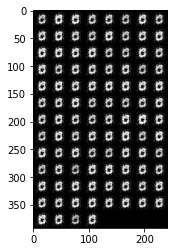

Cropped/greyscaled


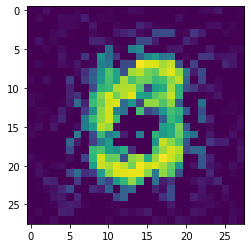

predicted: 0
Generated


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


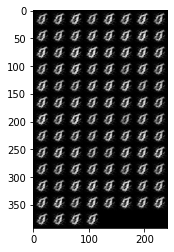

Cropped/greyscaled


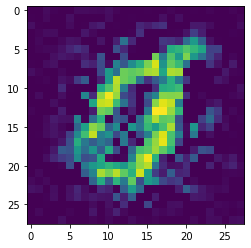

predicted: 0
Generated


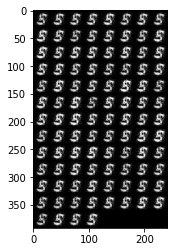

Cropped/greyscaled


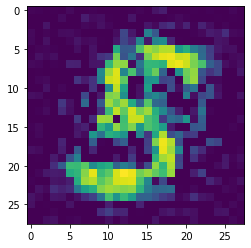

predicted: 5
Generated


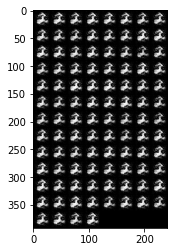

Cropped/greyscaled


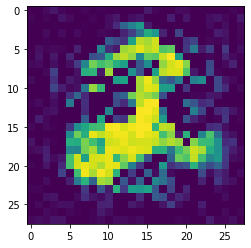

predicted: 2
Generated


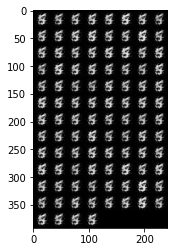

Cropped/greyscaled


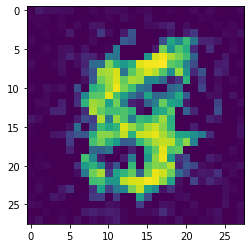

predicted: 5
Generated


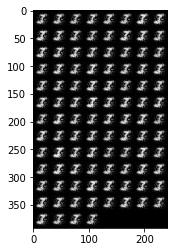

Cropped/greyscaled


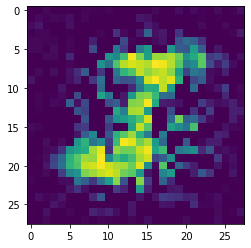

predicted: 2
Generated


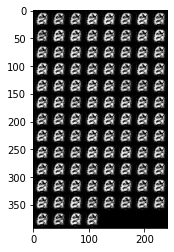

Cropped/greyscaled


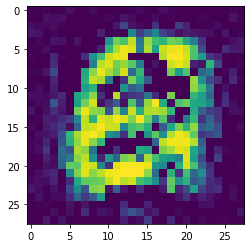

predicted: 5
Generated


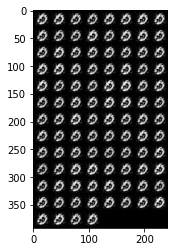

Cropped/greyscaled


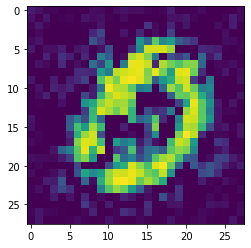

predicted: 0
Generated


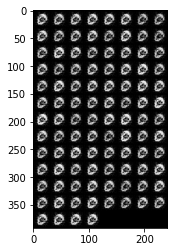

Cropped/greyscaled


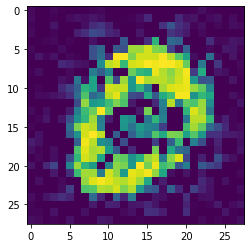

predicted: 0
Generated


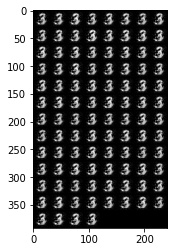

Cropped/greyscaled


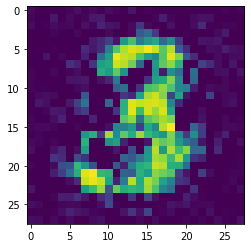

predicted: 3
Generated


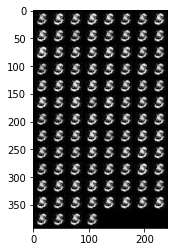

Cropped/greyscaled


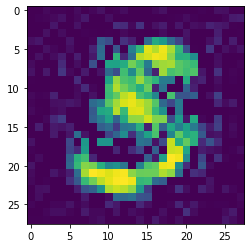

predicted: 3
Generated


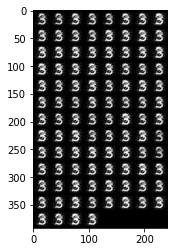

Cropped/greyscaled


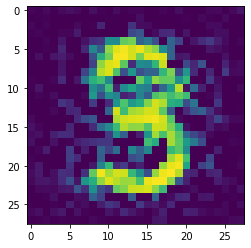

predicted: 3
Generated


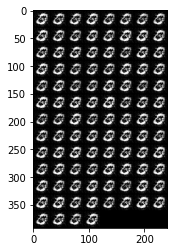

Cropped/greyscaled


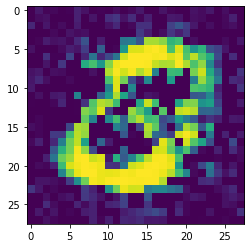

predicted: 5
Generated


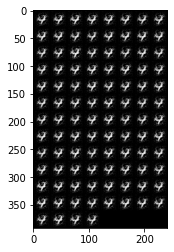

Cropped/greyscaled


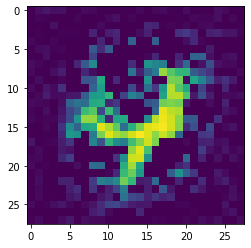

predicted: 4
Generated


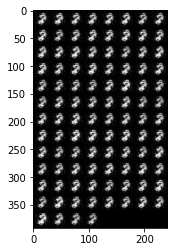

Cropped/greyscaled


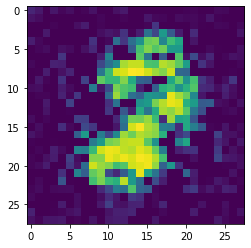

predicted: 2
Generated


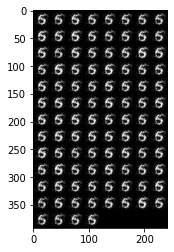

Cropped/greyscaled


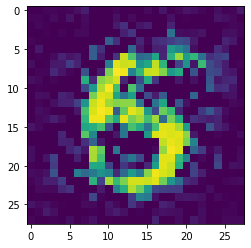

predicted: 5
Generated


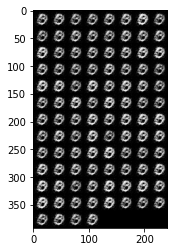

Cropped/greyscaled


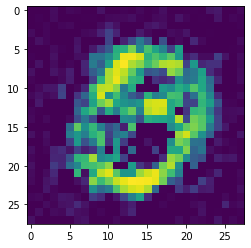

predicted: 0
Generated


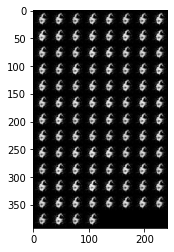

Cropped/greyscaled


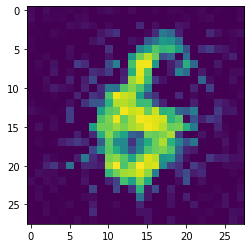

predicted: 6
Generated


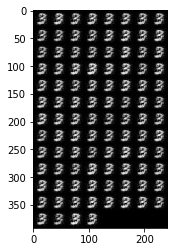

Cropped/greyscaled


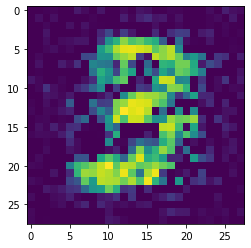

predicted: 3
Generated


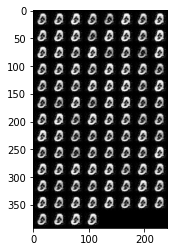

Cropped/greyscaled


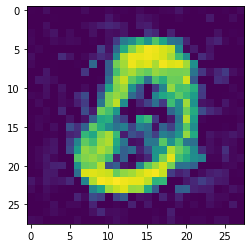

predicted: 0
Generated


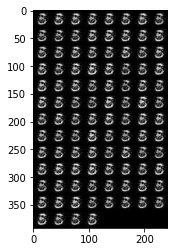

Cropped/greyscaled


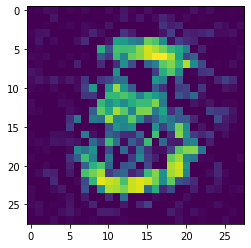

predicted: 5
Generated


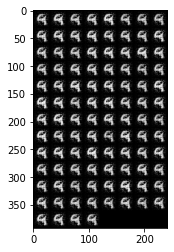

Cropped/greyscaled


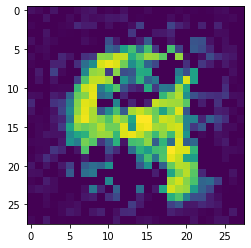

predicted: 4
Generated


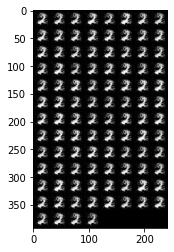

Cropped/greyscaled


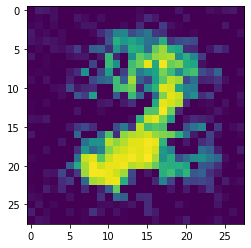

predicted: 2
Generated


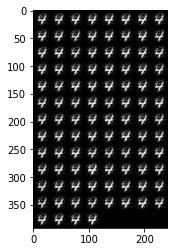

Cropped/greyscaled


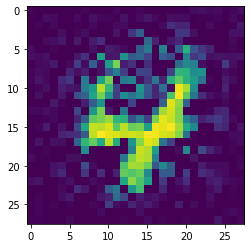

predicted: 4
Generated


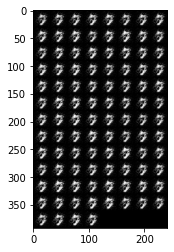

Cropped/greyscaled


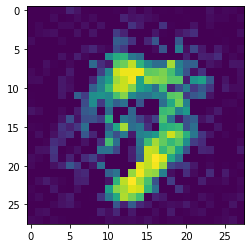

predicted: 7


In [52]:
import matplotlib.pyplot as plt

from PIL import Image
import torchvision.transforms.functional as TF
import os
from torchvision.transforms import Grayscale
scaler = Grayscale(1)
for filename in os.listdir('to_classify'):
  print('Generated')
  image = Image.open(os.path.join('to_classify',filename))
  plt.imshow(image)
  plt.show()
  crop_rectangle = (2, 2, 30, 30) #crop to 28 x 28
  cropped_im = image.crop(crop_rectangle)
  cropped_im = scaler(cropped_im) #convert to grayscale
  print('Cropped/greyscaled')
  plt.imshow(cropped_im)
  plt.show()
  x = TF.to_tensor(cropped_im).to(device)
  model_input = x.view(-1, 784)
  out = model(model_input)
  arg_maxed = torch.argmax(out, dim = 1)
  print('predicted: {}'.format(arg_maxed.item()))
